# Importing libraries

In [1]:
import pandas as pd     # for calculation
import numpy as np

from sklearn.experimental import enable_iterative_imputer   # for mssing values calculation
from sklearn.impute import IterativeImputer
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt     # for graph

from sklearn.cluster import DBSCAN  # for outliers

# User-Defined Function (UDF)

In [2]:
# creating a function for monthly calculation from yearly and weakly 
def monthly(x, value):
    if x in [409,419, 619, 649]:
        return (value * 30)/ 365
    elif x in [169, 219, 239, 249, 189, 269, 279, 199, 289, 299, 309, 319, 329]:
        return (value * 30)/ 7
    else:
        return value

In [3]:
# creating a function for sector and state spliting from Common-id
def split_string(s):
    part0 = s[:13]   # first 13 bytes
    part1 = s[13:14]  # next 2 bytes
    part2 = s[14:16]  # next 2 bytes
    part3 = s[16:]   # remaining bytes
    return pd.Series([part0,part1, part2, part3]) 

# Importing data

In [4]:
# Importing level 2 data from divice
col_specification=[(0,38),(38,39),(39,41),(41,43),(43,44),(44,45),(45,48),(48,49),(49,51),(51,53),(53,54),(54,56),(56,57),(57,59),(59,61),(61,63),(63,65),(65,67),(67,68),(68,69),(69,84)]
col_names=['Common-ID','Questionnaire No.','Level','Person Srl No.','Relation to head (code)','Gender','Age(in years)','Marital Status (code)','Highest educational level attained (code)','Total year of education completed','Whether used internet from any location during last 30 days','No. of days stayed away from home during last 30 days','No. of meals usually taken in a day','No. of meals taken during last 30 days from school, balwadi etc.','No. of meals taken during last 30 days  others','No. of meals taken during last 30 days from employer as perquisites or part of wage','No. of meals taken during last 30 days at home','No. of meals taken during last 30 days on payment','FDQ original member(generated field)','Status of Member as on revisit','Multiplier']
level_2= pd.read_fwf(r'F:\DATA\D_work\Interpreation\hces22_lvl_02.txt', header=None, colspecs=col_specification, names = col_names)
level_2.head(5)

,Common-ID,Questionnaire No.,Level,Person Srl No.,Relation to head (code),Gender,Age(in years),Marital Status (code),Highest educational level attained (code),Total year of education completed,...,No. of days stayed away from home during last 30 days,No. of meals usually taken in a day,"No. of meals taken during last 30 days from school, balwadi etc.",No. of meals taken during last 30 days others,No. of meals taken during last 30 days from employer as perquisites or part of wage,No. of meals taken during last 30 days at home,No. of meals taken during last 30 days on payment,FDQ original member(generated field),Status of Member as on revisit,Multiplier
0,HCES2022655561010131113011 101202 201,H,2,1,1,1,48,2,6,12.0,...,0.0,2.0,0.0,0.0,0.0,0.0,58.0,1,1.0,35560.0
1,HCES2022655561010131113011 101202 201,H,2,2,2,2,46,2,1,NaN,...,0.0,2.0,NaN,NaN,NaN,NaN,60.0,1,1.0,35560.0
2,HCES2022655561010131113011 101202 201,H,2,3,5,1,24,1,13,18.0,...,0.0,2.0,NaN,NaN,NaN,NaN,58.0,1,1.0,35560.0
3,HCES2022655561010131113011 101202 201,H,2,4,5,1,18,1,7,13.0,...,0.0,2.0,NaN,NaN,NaN,NaN,56.0,1,1.0,35560.0
4,HCES2022655561010131113011 101202 201,H,2,5,5,2,21,1,12,17.0,...,0.0,2.0,NaN,NaN,NaN,NaN,54.0,1,1.0,35560.0


In [5]:
# Importing level-14 data from device
col_specification=[(0,38),(38,39),(39,41),(41,46),(46,49),(49,59),(59,74)]
col_names=['Common-ID','Questionnaire No.','Level','Section','Item Code','Value (in Rs)','Multiplier']
lvl_14= pd.read_fwf(r'F:\DATA\D_work\Interpreation\hces22_lvl_14.txt', header=None, colspecs=col_specification, names = col_names)
lvl_14.head(5)

,Common-ID,Questionnaire No.,Level,Section,Item Code,Value (in Rs),Multiplier
0,HCES2022655621010121713017 101111 301,F,14,5.1,139,90,8890.0
1,HCES2022655621010121713017 101111 310,F,14,5.1,139,90,8890.0
2,HCES2022655621010121713017 101111 311,F,14,5.1,139,25,8890.0
3,HCES2022655621010121713017 101111 313,F,14,5.1,139,45,8890.0
4,HCES2022655371010122023014 201111 202,F,14,5.1,139,75,140500.0


### Primary cleanning
Splitting the non-usable column and multiplier divided by 100 as defined in the "read me" word file

In [6]:
# for counting total number of members of a household
lvl_2 = level_2.value_counts('Common-ID').to_frame().reset_index()
lvl_2.head(5)

,Common-ID,count
0,HCES2022666371080811523175 108112 107,37
1,HCES2022341462363612342036 236101 1312,31
2,HCES2022636211090934223383 109205 303,30
3,HCES2022670621353510123017 235101 203,29
4,HCES2022636811090920723403 109125 308,28


In [7]:
# Dropping level and Section from data frame (lvl_14)
level_14 = lvl_14.drop(['Level','Section'],axis=1)
level_14.head(5)

,Common-ID,Questionnaire No.,Item Code,Value (in Rs),Multiplier
0,HCES2022655621010121713017 101111 301,F,139,90,8890.0
1,HCES2022655621010121713017 101111 310,F,139,90,8890.0
2,HCES2022655621010121713017 101111 311,F,139,25,8890.0
3,HCES2022655621010121713017 101111 313,F,139,45,8890.0
4,HCES2022655371010122023014 201111 202,F,139,75,140500.0


In [8]:
# As provided in "Read me" text dividing multiplier by 100
level_14['Multiplier'] = level_14['Multiplier']/100
level_14.head(5)

,Common-ID,Questionnaire No.,Item Code,Value (in Rs),Multiplier
0,HCES2022655621010121713017 101111 301,F,139,90,88.9
1,HCES2022655621010121713017 101111 310,F,139,90,88.9
2,HCES2022655621010121713017 101111 311,F,139,25,88.9
3,HCES2022655621010121713017 101111 313,F,139,45,88.9
4,HCES2022655371010122023014 201111 202,F,139,75,1405.0


In [9]:
level_14.count()

Common-ID            8075528
Questionnaire No.    8075528
Item Code            8075528
Value (in Rs)        8075528
Multiplier           8075528
dtype: int64

## Appling monthly function
so we can read monthly expendeture

In [10]:
# Creating a new column for monthly calculated values using monthly function
level_14['Monthly Value'] = level_14.apply(lambda row: monthly(row['Item Code'], row['Value (in Rs)']), axis=1)
level_14.head(5)

,Common-ID,Questionnaire No.,Item Code,Value (in Rs),Multiplier,Monthly Value
0,HCES2022655621010121713017 101111 301,F,139,90,88.9,90.0
1,HCES2022655621010121713017 101111 310,F,139,90,88.9,90.0
2,HCES2022655621010121713017 101111 311,F,139,25,88.9,25.0
3,HCES2022655621010121713017 101111 313,F,139,45,88.9,45.0
4,HCES2022655371010122023014 201111 202,F,139,75,1405.0,75.0


# One item study
For checking data is representing correctly or not we only study 'Item code' 169 for milk and milk products 

In [11]:
# Filtering the data-frame for checking milk & milk prodect consumption in a single housee hold
##checking if monthly funtion is functioning properly
temp1 = level_14[level_14['Item Code'].isin([169])]
temp1.head(5)

,Common-ID,Questionnaire No.,Item Code,Value (in Rs),Multiplier,Monthly Value
12875,HCES2022653651030311613011 103123 2301,F,169,630,1501.65,2700.000000
12885,HCES2022653651030311613011 103123 2302,F,169,935,1501.65,4007.142857
12896,HCES2022653651030311613011 103123 2303,F,169,560,1501.65,2400.000000
12904,HCES2022653651030311613011 103123 2305,F,169,1380,1501.65,5914.285714
12912,HCES2022653651030311613011 103123 2306,F,169,518,1501.65,2220.000000


here,
(630/7)*30 = 2700
it means monthly function is working properly (i only confirmed for 7 days calculation, on that basis i assumed that it is functioning well for 365 to 30 days also)

In [12]:
# description of monthly value only for milk & milk prodects ('169') 
temp1['Monthly Value'].describe()

count    247522.000000
mean       1660.435090
std        1991.656250
min          21.428571
25%         642.857143
50%        1200.000000
75%        2142.857143
max      563571.428571
Name: Monthly Value, dtype: float64

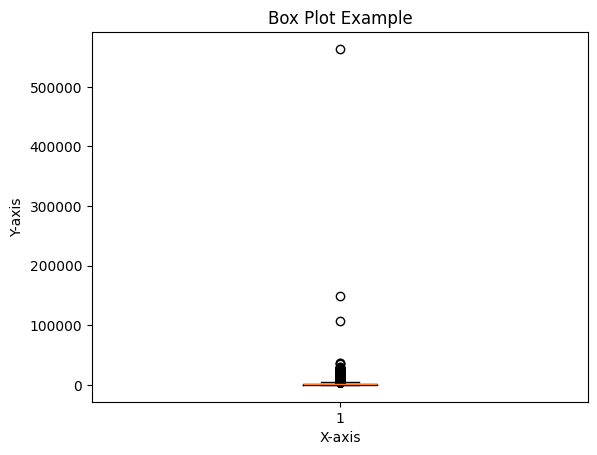

In [13]:
# Data for the box plot
data = temp1['Monthly Value']

# Create the box plot
plt.boxplot(data)

# Add title and labels
plt.title("Box Plot Example")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()

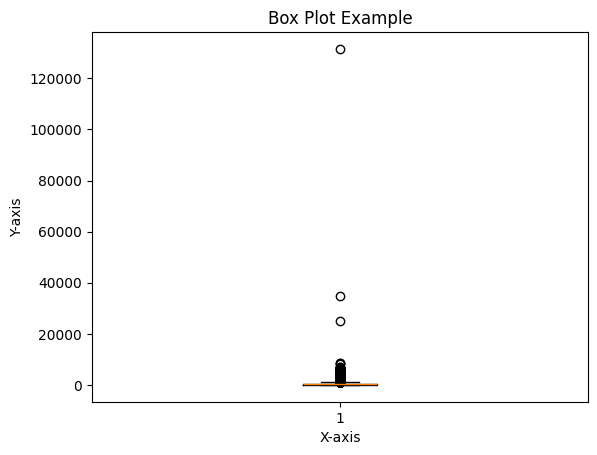

In [14]:
# Data for the box plot
data1 = temp1['Value (in Rs)']

# Create the box plot
plt.boxplot(data1)

# Add title and labels
plt.title("Box Plot Example")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()

In [15]:
# mergeing data of lvl_2 and temp1 for milk(169) conmpution and toal number of members of a household
temp2 = lvl_2.merge(temp1, on='Common-ID', how='left')
temp2.head(5)

,Common-ID,count,Questionnaire No.,Item Code,Value (in Rs),Multiplier,Monthly Value
0,HCES2022666371080811523175 108112 107,37,F,169.0,2550.0,1852.97,10928.571429
1,HCES2022341462363612342036 236101 1312,31,F,169.0,1200.0,1859.42,5142.857143
2,HCES2022636211090934223383 109205 303,30,F,169.0,4150.0,2087.25,17785.714286
3,HCES2022670621353510123017 235101 203,29,F,169.0,1010.0,88.19,4328.571429
4,HCES2022636811090920723403 109125 308,28,F,169.0,3370.0,1394.85,14442.857143


In [16]:
#  Creating predication for missing values
#  Select the columns to impute
columns_to_impute = ['Value (in Rs)','Multiplier','Monthly Value','Item Code']

# Create an imputer object
imputer = IterativeImputer()

# Fit and transform the data, only for the selected columns
imputed_data = imputer.fit_transform(temp2[columns_to_impute])

# Convert back to dataframe
imputed_df = pd.DataFrame(imputed_data, columns=columns_to_impute)

# Drop the original columns from temp2
temp2_dropped = temp2.drop(columns=columns_to_impute)

In [17]:
# creating an new dataframe named as milk which consists of milk & milk products '169' in each households
merged_df = pd.merge(temp2_dropped,imputed_df, left_index=True, right_index=True)
milk = merged_df.drop(['Questionnaire No.','Item Code'],axis=1)
milk.head(5)

,Common-ID,count,Value (in Rs),Multiplier,Monthly Value
0,HCES2022666371080811523175 108112 107,37,2550.0,1852.97,10928.571429
1,HCES2022341462363612342036 236101 1312,31,1200.0,1859.42,5142.857143
2,HCES2022636211090934223383 109205 303,30,4150.0,2087.25,17785.714286
3,HCES2022670621353510123017 235101 203,29,1010.0,88.19,4328.571429
4,HCES2022636811090920723403 109125 308,28,3370.0,1394.85,14442.857143


In [18]:
# making data for per person
milk['per_person'] = milk['Monthly Value']/milk['count']
milk.head(3)

,Common-ID,count,Value (in Rs),Multiplier,Monthly Value,per_person
0,HCES2022666371080811523175 108112 107,37,2550.0,1852.97,10928.571429,295.366795
1,HCES2022341462363612342036 236101 1312,31,1200.0,1859.42,5142.857143,165.898618
2,HCES2022636211090934223383 109205 303,30,4150.0,2087.25,17785.714286,592.857143


In [19]:
# checking a statistcal values
milk.describe()

,count,Value (in Rs),Multiplier,Monthly Value,per_person
count,261746.000000,261746.000000,261746.000000,261746.000000,261746.000000
mean,4.305850,387.434854,1078.297779,1660.435090,435.492918
std,2.114834,451.916291,1097.390096,1936.784103,546.175553
min,1.000000,5.000000,4.720000,21.428571,3.061224
25%,3.000000,155.000000,594.680000,664.285714,176.785714
50%,4.000000,295.000000,1078.297779,1264.285714,321.428571
75%,5.000000,480.000000,1448.660000,2057.142857,553.478363
max,37.000000,131500.000000,96600.600000,563571.428571,187857.142857


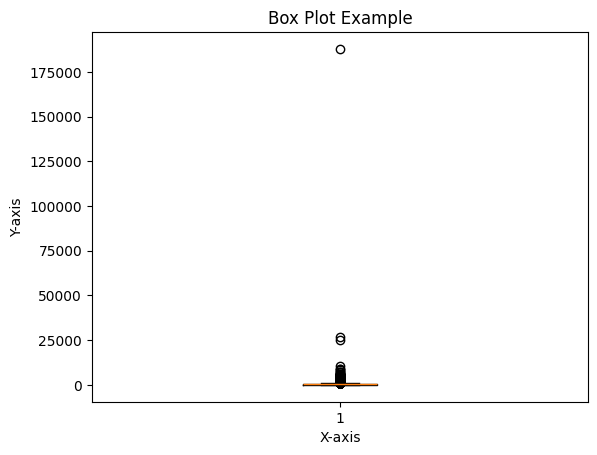

In [20]:
# Data for the box plot
data1 = milk['per_person']

# Create the box plot
plt.boxplot(data1)

# Add title and labels
plt.title("Box Plot Example")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()

In [21]:
data1 = milk['per_person']
data1 = data1.values.reshape(-1, 1)  # reshape to 2D array
dbscan = DBSCAN(eps=3, min_samples=2)
outliers = data1[dbscan.fit_predict(data1) == -1]

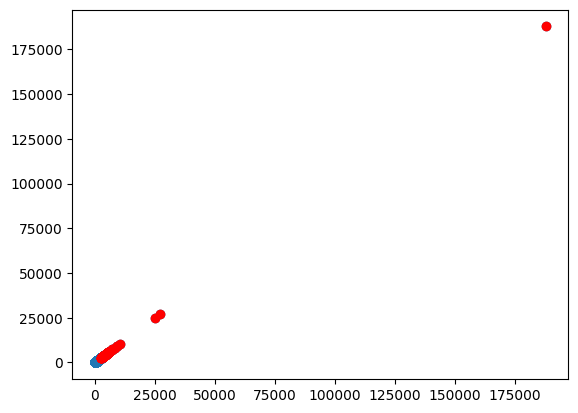

In [22]:
plt.scatter(data1[:, 0], data1[:, 0])
plt.scatter(outliers[:, 0], outliers[:, 0], c='red')
plt.show()

In [23]:
len(outliers)

116

In [27]:
len(data1)

261746

In [30]:
# Flatten the arrays for efficient comparison
x_flat = data1.flatten()
y_flat = outliers.flatten()

# Find the indices of values in x that are also in y
indices_to_remove = np.where(np.isin(x_flat, y_flat))[0]

# Remove those values from x
x_remaining = np.delete(x_flat, indices_to_remove)

len(x_remaining)

261630

2,61,746 to 8040????/

In [31]:
# Remove outliers
per_person_without_outlier = pd.DataFrame(x_remaining)
per_person_without_outlier = per_person_without_outlier.rename(columns={0:'value'})
per_person_without_outlier.describe()

,value
count,261630.000000
mean,432.913201
std,389.744940
min,3.061224
25%,176.785714
50%,321.428571
75%,553.478363
max,5485.714286


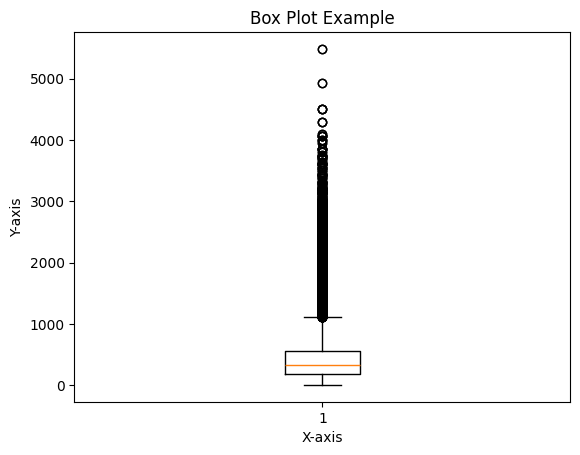

In [32]:
# Data for the box plot
data5 = per_person_without_outlier['value']

# Create the box plot
plt.boxplot(data5)

# Add title and labels
plt.title("Box Plot Example")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()

After performing some calculations on a sample item (milk : "169") to check data clean quality.

# Now on full data
### now trying same method to cleaning

In [15]:
# Filtering only FDQ items from level 14 for creating a new data frame 
FDQ = level_14[level_14['Questionnaire No.'].isin(['F'])]
FDQ.head(5)

,Common-ID,Questionnaire No.,Item Code,Value (in Rs),Multiplier,Monthly Value
0,HCES2022655621010121713017 101111 301,F,139,90,88.9,90.0
1,HCES2022655621010121713017 101111 310,F,139,90,88.9,90.0
2,HCES2022655621010121713017 101111 311,F,139,25,88.9,25.0
3,HCES2022655621010121713017 101111 313,F,139,45,88.9,45.0
4,HCES2022655371010122023014 201111 202,F,139,75,1405.0,75.0


FDQ_new = FDQ.groupby('Common-ID')['Total Expenditure'].sum().to_frame()
FDQ_new.reset_index().head(5)

In [16]:
FDQ_new = FDQ.groupby('Common-ID')['Monthly Value'].sum().to_frame()
FDQ_new.reset_index().head(5)

,Common-ID,Monthly Value
0,HCES2022310002282831212025 228111 301,8704.428571
1,HCES2022310002282831212025 228111 302,13032.428571
2,HCES2022310002282831212025 228111 303,13252.857143
3,HCES2022310002282831212025 228111 304,5644.285714
4,HCES2022310002282831212025 228111 305,1263.142857


In [17]:
CSQ = level_14[level_14['Questionnaire No.'].isin(['C'])]
CSQ.head(5)

,Common-ID,Questionnaire No.,Item Code,Value (in Rs),Multiplier,Monthly Value
3149267,HCES2022655561010131113011 101202 201,C,349,1960,355.60,1960.0
3149268,HCES2022655561010131113011 101202 301,C,349,1620,303.31,1620.0
3149269,HCES2022655561010131113011 101202 302,C,349,1845,303.31,1845.0
3149270,HCES2022655561010131113011 101202 303,C,349,1520,303.31,1520.0
3149271,HCES2022655561010131113011 101202 304,C,349,1280,303.31,1280.0


CSQ_new = CSQ.groupby('Common-ID')['Total Expenditure'].sum().to_frame()
CSQ_new.reset_index().head(5)

In [18]:
CSQ_new = CSQ.groupby('Common-ID')['Monthly Value'].sum().to_frame()
CSQ_new.reset_index().head(5)

,Common-ID,Monthly Value
0,HCES2022310002282831212025 228111 301,9655.571429
1,HCES2022310002282831212025 228111 302,24088.469667
2,HCES2022310002282831212025 228111 303,21439.287671
3,HCES2022310002282831212025 228111 304,11276.000000
4,HCES2022310002282831212025 228111 305,9639.000000


In [19]:
DGQ = level_14[level_14['Questionnaire No.'].isin(['D'])]
DGQ.head(5)

,Common-ID,Questionnaire No.,Item Code,Value (in Rs),Multiplier,Monthly Value
5689781,HCES2022655561010131113011 101202 201,D,379,8470,355.60,8470.0
5689782,HCES2022655561010131113011 101202 201,D,389,1100,355.60,1100.0
5689783,HCES2022655561010131113011 101202 201,D,399,2210,355.60,2210.0
5689784,HCES2022655561010131113011 101202 301,D,379,7990,303.31,7990.0
5689785,HCES2022655561010131113011 101202 301,D,389,1300,303.31,1300.0


DGQ_new = DGQ.groupby('Common-ID')['Total Expenditure'].sum().to_frame()
DGQ_new.reset_index().head(5)

In [20]:
DGQ_new = DGQ.groupby('Common-ID')['Monthly Value'].sum().to_frame()
DGQ_new.reset_index().head(5)

,Common-ID,Monthly Value
0,HCES2022310002282831212025 228111 301,16007.000000
1,HCES2022310002282831212025 228111 302,38007.534247
2,HCES2022310002282831212025 228111 303,40848.630137
3,HCES2022310002282831212025 228111 304,20102.479452
4,HCES2022310002282831212025 228111 305,13190.000000


m_fdq = lvl_2.merge(FDQ_new, on='Common-ID', how='left').fillna(0).reset_index()
m_fdq_rnme = m_fdq.rename(columns={'count':'Total_mambers_in_a _household'})
m_fdq_rnme = m_fdq_rnme.rename(columns={'Total Expenditure':'FDQ_Expenditure'})
m_fdq_rnme = m_fdq_rnme.rename(columns={'Common-ID':'Common-ID'})
m_fdq_rnme.head(5)

In [21]:
m_fdq = lvl_2.merge(FDQ_new, on='Common-ID', how='left').fillna(0).reset_index()
m_fdq_rnme = m_fdq.rename(columns={'count':'Total_mambers_in_a _household'})
m_fdq_rnme = m_fdq_rnme.rename(columns={'Monthly Value':'FDQ_Expenditure'})
m_fdq_rnme = m_fdq_rnme.rename(columns={'Common-ID':'Common-ID'})
m_fdq_rnme.head(5)

,index,Common-ID,Total_mambers_in_a _household,FDQ_Expenditure
0,0,HCES2022666371080811523175 108112 107,37,41464.285714
1,1,HCES2022341462363612342036 236101 1312,31,54941.714286
2,2,HCES2022636211090934223383 109205 303,30,51555.714286
3,3,HCES2022670621353510123017 235101 203,29,67632.857143
4,4,HCES2022636811090920723403 109125 308,28,35376.714286


m_csq = m_fdq_rnme.merge(CSQ_new, on='Common-ID', how='left').fillna(0)
m_csq_rnme = m_csq.rename(columns={'Total Expenditure':'CSQ_Expenditure'})
m_csq_rnme.head(5)

In [22]:
m_csq = m_fdq_rnme.merge(CSQ_new, on='Common-ID', how='left').fillna(0)
m_csq_rnme = m_csq.rename(columns={'Monthly Value':'CSQ_Expenditure'})
m_csq_rnme.head(5)

,index,Common-ID,Total_mambers_in_a _household,FDQ_Expenditure,CSQ_Expenditure
0,0,HCES2022666371080811523175 108112 107,37,41464.285714,75531.917808
1,1,HCES2022341462363612342036 236101 1312,31,54941.714286,40329.442270
2,2,HCES2022636211090934223383 109205 303,30,51555.714286,15594.958904
3,3,HCES2022670621353510123017 235101 203,29,67632.857143,42001.722114
4,4,HCES2022636811090920723403 109125 308,28,35376.714286,7943.571429


m_dgq = m_csq_rnme.merge(DGQ_new, on='Common-ID', how='left').fillna(0)
m_dgq_rnme = m_dgq.rename(columns={'Total Expenditure':'DGQ_Expenditure'})
main = m_dgq_rnme.drop(['index'],axis=1)
main.head(5)

In [23]:
m_dgq = m_csq_rnme.merge(DGQ_new, on='Common-ID', how='left').fillna(0)
m_dgq_rnme = m_dgq.rename(columns={'Monthly Value':'DGQ_Expenditure'})
main = m_dgq_rnme.drop(['index'],axis=1)
main.head(5)

,Common-ID,Total_mambers_in_a _household,FDQ_Expenditure,CSQ_Expenditure,DGQ_Expenditure
0,HCES2022666371080811523175 108112 107,37,41464.285714,75531.917808,74250.000000
1,HCES2022341462363612342036 236101 1312,31,54941.714286,40329.442270,121801.986301
2,HCES2022636211090934223383 109205 303,30,51555.714286,15594.958904,63739.863014
3,HCES2022670621353510123017 235101 203,29,67632.857143,42001.722114,207784.931507
4,HCES2022636811090920723403 109125 308,28,35376.714286,7943.571429,49614.616438


In [24]:
main ['one_fdq'] = main['FDQ_Expenditure']/main['Total_mambers_in_a _household']
main ['one_csq'] = main['CSQ_Expenditure']/main['Total_mambers_in_a _household']
main ['one_dgq'] = main['DGQ_Expenditure']/main['Total_mambers_in_a _household']
main.head(5)

,Common-ID,Total_mambers_in_a _household,FDQ_Expenditure,CSQ_Expenditure,DGQ_Expenditure,one_fdq,one_csq,one_dgq
0,HCES2022666371080811523175 108112 107,37,41464.285714,75531.917808,74250.000000,1120.656371,2041.403184,2006.756757
1,HCES2022341462363612342036 236101 1312,31,54941.714286,40329.442270,121801.986301,1772.313364,1300.949751,3929.096332
2,HCES2022636211090934223383 109205 303,30,51555.714286,15594.958904,63739.863014,1718.523810,519.831963,2124.662100
3,HCES2022670621353510123017 235101 203,29,67632.857143,42001.722114,207784.931507,2332.167488,1448.335245,7164.997638
4,HCES2022636811090920723403 109125 308,28,35376.714286,7943.571429,49614.616438,1263.454082,283.698980,1771.950587


In [25]:
main['FDQ_Expenditure'].describe()

count    261746.000000
mean       8977.688029
std        5995.689343
min           0.000000
25%        5534.857143
50%        7922.857143
75%       11105.107143
max      757670.428571
Name: FDQ_Expenditure, dtype: float64

In [26]:
main['CSQ_Expenditure'].describe()

count    2.617460e+05
mean     1.115549e+04
std      1.242663e+04
min      0.000000e+00
25%      5.115401e+03
50%      8.530885e+03
75%      1.387655e+04
max      3.139109e+06
Name: CSQ_Expenditure, dtype: float64

In [27]:
main['DGQ_Expenditure'].describe()

count    2.617460e+05
mean     2.874372e+04
std      4.902629e+04
min      0.000000e+00
25%      1.168118e+04
50%      1.988510e+04
75%      3.312663e+04
max      3.047822e+06
Name: DGQ_Expenditure, dtype: float64

In [31]:
mult = level_2.groupby('Common-ID')['Multiplier'].unique().to_frame()
mult

,Multiplier
Common-ID,
HCES2022310002282831212025 228111 301,[96498.0]
HCES2022310002282831212025 228111 302,[96498.0]
HCES2022310002282831212025 228111 303,[96498.0]
HCES2022310002282831212025 228111 304,[96498.0]
HCES2022310002282831212025 228111 305,[96498.0]
...,...
HCES2022699991212130123093 221201 312,[125023.0]
HCES2022699991212130123093 221201 313,[125023.0]
HCES2022699991212130123093 221201 314,[125023.0]


In [32]:
mult_lvl_2 = lvl_2.merge(mult, on ='Common-ID', how='left').fillna(0).reset_index()
mult_lvl_2 = mult_lvl_2.drop(['index'],axis=1)
mult_lvl_2

,Common-ID,count,Multiplier
0,HCES2022666371080811523175 108112 107,37,[185297.0]
1,HCES2022341462363612342036 236101 1312,31,[185942.0]
2,HCES2022636211090934223383 109205 303,30,[208725.0]
3,HCES2022670621353510123017 235101 203,29,[8819.0]
4,HCES2022636811090920723403 109125 308,28,[139485.0]
...,...,...,...
261741,HCES2022699941212130623094 121111 316,1,[188261.0]
261742,HCES2022310022282831012022 228101 306,1,[125146.0]
261743,HCES2022310022282831012022 228101 311,1,[125146.0]
261744,HCES2022310002282831212025 228111 314,1,[96498.0]


In [35]:
mult_lvl_2['real_count'] = mult_lvl_2['count']*mult_lvl_2['Multiplier']
mult_lvl_2

,Common-ID,count,Multiplier,real_count
0,HCES2022666371080811523175 108112 107,37,[185297.0],[6855989.0]
1,HCES2022341462363612342036 236101 1312,31,[185942.0],[5764202.0]
2,HCES2022636211090934223383 109205 303,30,[208725.0],[6261750.0]
3,HCES2022670621353510123017 235101 203,29,[8819.0],[255751.0]
4,HCES2022636811090920723403 109125 308,28,[139485.0],[3905580.0]
...,...,...,...,...
261741,HCES2022699941212130623094 121111 316,1,[188261.0],[188261.0]
261742,HCES2022310022282831012022 228101 306,1,[125146.0],[125146.0]
261743,HCES2022310022282831012022 228101 311,1,[125146.0],[125146.0]
261744,HCES2022310002282831212025 228111 314,1,[96498.0],[96498.0]


In [36]:
# Calculating total expanditure on the base of monthly value
mult_applied = level_14.copy()
mult_applied['Total Expenditure'] = mult_applied['Monthly Value']*mult_applied['Multiplier']
mult_applied.head(5)

,Common-ID,Questionnaire No.,Item Code,Value (in Rs),Multiplier,Monthly Value,Total Expenditure
0,HCES2022655621010121713017 101111 301,F,139,90,88.9,90.0,8001.0
1,HCES2022655621010121713017 101111 310,F,139,90,88.9,90.0,8001.0
2,HCES2022655621010121713017 101111 311,F,139,25,88.9,25.0,2222.5
3,HCES2022655621010121713017 101111 313,F,139,45,88.9,45.0,4000.5
4,HCES2022655371010122023014 201111 202,F,139,75,1405.0,75.0,105375.0


In [37]:
FDQ_m = mult_applied[mult_applied['Questionnaire No.'].isin(['F'])]
FDQ_m.head(5)

,Common-ID,Questionnaire No.,Item Code,Value (in Rs),Multiplier,Monthly Value,Total Expenditure
0,HCES2022655621010121713017 101111 301,F,139,90,88.9,90.0,8001.0
1,HCES2022655621010121713017 101111 310,F,139,90,88.9,90.0,8001.0
2,HCES2022655621010121713017 101111 311,F,139,25,88.9,25.0,2222.5
3,HCES2022655621010121713017 101111 313,F,139,45,88.9,45.0,4000.5
4,HCES2022655371010122023014 201111 202,F,139,75,1405.0,75.0,105375.0


In [38]:
FDQ_new_m = FDQ_m.groupby('Common-ID')['Total Expenditure'].sum().to_frame()
FDQ_new_m.reset_index().head(5)

,Common-ID,Total Expenditure
0,HCES2022310002282831212025 228111 301,8.399599e+06
1,HCES2022310002282831212025 228111 302,1.257603e+07
2,HCES2022310002282831212025 228111 303,1.278874e+07
3,HCES2022310002282831212025 228111 304,5.446623e+06
4,HCES2022310002282831212025 228111 305,1.218908e+06


In [39]:
CSQ_m = mult_applied[mult_applied['Questionnaire No.'].isin(['C'])]
CSQ_m.head(5)

,Common-ID,Questionnaire No.,Item Code,Value (in Rs),Multiplier,Monthly Value,Total Expenditure
3149267,HCES2022655561010131113011 101202 201,C,349,1960,355.60,1960.0,696976.00
3149268,HCES2022655561010131113011 101202 301,C,349,1620,303.31,1620.0,491362.20
3149269,HCES2022655561010131113011 101202 302,C,349,1845,303.31,1845.0,559606.95
3149270,HCES2022655561010131113011 101202 303,C,349,1520,303.31,1520.0,461031.20
3149271,HCES2022655561010131113011 101202 304,C,349,1280,303.31,1280.0,388236.80


In [40]:
CSQ_new_m = CSQ_m.groupby('Common-ID')['Total Expenditure'].sum().to_frame()
CSQ_new_m.reset_index().head(5)

,Common-ID,Total Expenditure
0,HCES2022310002282831212025 228111 301,9.317433e+06
1,HCES2022310002282831212025 228111 302,2.324489e+07
2,HCES2022310002282831212025 228111 303,2.068848e+07
3,HCES2022310002282831212025 228111 304,1.088111e+07
4,HCES2022310002282831212025 228111 305,9.301442e+06


In [41]:
DGQ_m = mult_applied[mult_applied['Questionnaire No.'].isin(['D'])]
DGQ_m.head(5)

,Common-ID,Questionnaire No.,Item Code,Value (in Rs),Multiplier,Monthly Value,Total Expenditure
5689781,HCES2022655561010131113011 101202 201,D,379,8470,355.60,8470.0,3011932.0
5689782,HCES2022655561010131113011 101202 201,D,389,1100,355.60,1100.0,391160.0
5689783,HCES2022655561010131113011 101202 201,D,399,2210,355.60,2210.0,785876.0
5689784,HCES2022655561010131113011 101202 301,D,379,7990,303.31,7990.0,2423446.9
5689785,HCES2022655561010131113011 101202 301,D,389,1300,303.31,1300.0,394303.0


In [42]:
DGQ_new_m = DGQ_m.groupby('Common-ID')['Total Expenditure'].sum().to_frame()
DGQ_new_m.reset_index().head(5)

,Common-ID,Total Expenditure
0,HCES2022310002282831212025 228111 301,1.544643e+07
1,HCES2022310002282831212025 228111 302,3.667651e+07
2,HCES2022310002282831212025 228111 303,3.941811e+07
3,HCES2022310002282831212025 228111 304,1.939849e+07
4,HCES2022310002282831212025 228111 305,1.272809e+07


In [44]:

m_fdq_m = mult_lvl_2.merge(FDQ_new_m, on='Common-ID', how='left').fillna(0)
m_fdq_m_rnme = m_fdq_m.rename(columns={'real_count':'Total_mambers_in_a _household'})
m_fdq_m_rnme = m_fdq_m_rnme.rename(columns={'Total Expenditure':'FDQ_Expenditure'})
m_fdq_m_rnme = m_fdq_m_rnme.rename(columns={'Common-ID':'Common-ID'})
m_fdq_m_rnme.head(5)

,Common-ID,count,Multiplier,Total_mambers_in_a _household,FDQ_Expenditure
0,HCES2022666371080811523175 108112 107,37,[185297.0],[6855989.0],7.683208e+07
1,HCES2022341462363612342036 236101 1312,31,[185942.0],[5764202.0],1.021597e+08
2,HCES2022636211090934223383 109205 303,30,[208725.0],[6261750.0],1.076097e+08
3,HCES2022670621353510123017 235101 203,29,[8819.0],[255751.0],5.964542e+06
4,HCES2022636811090920723403 109125 308,28,[139485.0],[3905580.0],4.934521e+07


In [45]:
m_csq_m = m_fdq_m_rnme.merge(CSQ_new_m, on='Common-ID', how='left').fillna(0)
m_csq_m_rnme = m_csq_m.rename(columns={'Total Expenditure':'CSQ_Expenditure'})
m_csq_m_rnme.head(5)

,Common-ID,count,Multiplier,Total_mambers_in_a _household,FDQ_Expenditure,CSQ_Expenditure
0,HCES2022666371080811523175 108112 107,37,[185297.0],[6855989.0],7.683208e+07,1.399584e+08
1,HCES2022341462363612342036 236101 1312,31,[185942.0],[5764202.0],1.021597e+08,7.498937e+07
2,HCES2022636211090934223383 109205 303,30,[208725.0],[6261750.0],1.076097e+08,3.255058e+07
3,HCES2022670621353510123017 235101 203,29,[8819.0],[255751.0],5.964542e+06,3.704132e+06
4,HCES2022636811090920723403 109125 308,28,[139485.0],[3905580.0],4.934521e+07,1.108009e+07


In [47]:
m_dgq_m = m_csq_m_rnme.merge(DGQ_new_m, on='Common-ID', how='left').fillna(0) # type: ignore
m_dgq_m_rnme = m_dgq_m.rename(columns={'Total Expenditure':'DGQ_Expenditure'})
mult_main = m_dgq_m_rnme.copy()
mult_main.head(5)

,Common-ID,count,Multiplier,Total_mambers_in_a _household,FDQ_Expenditure,CSQ_Expenditure,DGQ_Expenditure
0,HCES2022666371080811523175 108112 107,37,[185297.0],[6855989.0],7.683208e+07,1.399584e+08,1.375830e+08
1,HCES2022341462363612342036 236101 1312,31,[185942.0],[5764202.0],1.021597e+08,7.498937e+07,2.264810e+08
2,HCES2022636211090934223383 109205 303,30,[208725.0],[6261750.0],1.076097e+08,3.255058e+07,1.330410e+08
3,HCES2022670621353510123017 235101 203,29,[8819.0],[255751.0],5.964542e+06,3.704132e+06,1.832455e+07
4,HCES2022636811090920723403 109125 308,28,[139485.0],[3905580.0],4.934521e+07,1.108009e+07,6.920495e+07


In [59]:
mult_main['one_fdq'] = mult_main['FDQ_Expenditure']/mult_main['Total_mambers_in_a _household']
mult_main['one_csq'] = mult_main['CSQ_Expenditure']/mult_main['Total_mambers_in_a _household']
mult_main['one_dgq'] = mult_main['DGQ_Expenditure']/mult_main['Total_mambers_in_a _household']
mult_main

,Common-ID,count,Multiplier,Total_mambers_in_a _household,FDQ_Expenditure,CSQ_Expenditure,DGQ_Expenditure,one_fdq,one_csq,one_dgq
0,HCES2022666371080811523175 108112 107,37,[185297.0],[6855989.0],7.683208e+07,1.399584e+08,1.375830e+08,[11.206563706563706],[20.414031840059238],[20.06756756756757]
1,HCES2022341462363612342036 236101 1312,31,[185942.0],[5764202.0],1.021597e+08,7.498937e+07,2.264810e+08,[17.723133640552994],[13.00949750647055],[39.29096332302254]
2,HCES2022636211090934223383 109205 303,30,[208725.0],[6261750.0],1.076097e+08,3.255058e+07,1.330410e+08,[17.185238095238095],[5.198319634703196],[21.246621004566208]
3,HCES2022670621353510123017 235101 203,29,[8819.0],[255751.0],5.964542e+06,3.704132e+06,1.832455e+07,[23.321674876847286],[14.483352452932046],[71.64997638167218]
4,HCES2022636811090920723403 109125 308,28,[139485.0],[3905580.0],4.934521e+07,1.108009e+07,6.920495e+07,[12.63454081632653],[2.836989795918367],[17.719505870841484]
...,...,...,...,...,...,...,...,...,...,...
261741,HCES2022699941212130623094 121111 316,1,[188261.0],[188261.0],5.985086e+06,6.929350e+06,1.118270e+07,[31.79142857142857],[36.80714285714286],[59.39999999999999]
261742,HCES2022310022282831012022 228101 306,1,[125146.0],[125146.0],9.090069e+06,7.184906e+06,1.294284e+07,[72.63571428571429],[57.412191780821914],[103.42191780821919]
261743,HCES2022310022282831012022 228101 311,1,[125146.0],[125146.0],1.017830e+07,6.637744e+06,1.400384e+07,[81.33142857142857],[53.04],[111.9]
261744,HCES2022310002282831212025 228111 314,1,[96498.0],[96498.0],7.486591e+06,1.112124e+07,1.892519e+07,[77.58285714285714],[115.24835616438355],[196.12]


In [49]:
mult_main['one_fdq'].mean()

array([23.74229821])

In [50]:
mult_main['one_csq'].mean()

array([31.54048315])

In [51]:
mult_main['one_dgq'].mean()

array([75.11782062])

# now i will try to check outliers using box plot

In [55]:
main.head(3)

,Common-ID,Total_mambers_in_a _household,FDQ_Expenditure,CSQ_Expenditure,DGQ_Expenditure,one_fdq,one_csq,one_dgq
0,HCES2022666371080811523175 108112 107,37,41464.285714,75531.917808,74250.000000,1120.656371,2041.403184,2006.756757
1,HCES2022341462363612342036 236101 1312,31,54941.714286,40329.442270,121801.986301,1772.313364,1300.949751,3929.096332
2,HCES2022636211090934223383 109205 303,30,51555.714286,15594.958904,63739.863014,1718.523810,519.831963,2124.662100


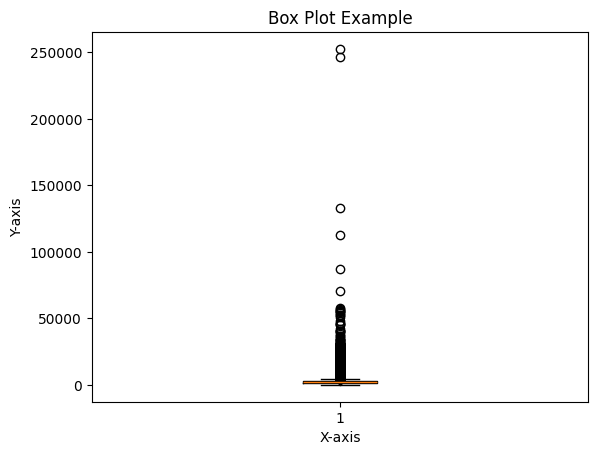

In [57]:
# Data for the box plot
data2 = main['one_fdq']

# Create the box plot
plt.boxplot(data2)

# Add title and labels
plt.title("Box Plot Example")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()

In [58]:
main['one_fdq'].describe()

count    261746.000000
mean       2374.229821
std        1840.777234
min           0.000000
25%        1437.357143
50%        1979.714286
75%        2791.857143
max      252556.809524
Name: one_fdq, dtype: float64